In [996]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import markdown2
import tabulate
from IPython.display import display, HTML, Markdown, Latex, Image

from sklearn.model_selection import train_test_split

In [1000]:
# Diamonds data
df_diamonds = pd.read_csv('./data/diamonds.csv')
df_dia_train, df_dia_test = train_test_split(df_diamonds, test_size=0.2)

In [943]:
# Boston data
from sklearn.datasets import load_boston
data = load_boston()
df_boston = pd.DataFrame(data.data, columns=[col.lower() for col in data.feature_names]).assign(PRICE = data.target)
df_boston_train, df_boston_test = train_test_split(df_boston, test_size=0.2)

In [951]:
# Titanic data
df_titanic = pd.read_csv('./data/titanic.csv')
df_titanic = (df_titanic
 .astype({'Survived':'object', 'Pclass':'object'})
)
df_titanic_train, df_titanic_test = train_test_split(df_titanic, test_size=0.2)
df_titanic_test = df_titanic_test.drop(columns=['Survived'])

# 0. Data Type Convert

In [950]:
# 기본적인 형변환 필요함
# 수작업으로 변환 + 컬럼 이름 조건 부여

def filter_by_tag(df, *args, cond='and', return_cols=True):
    '''
    태그 리스트를 기준으로 and/or 조건으로 해당하는 컬럼을 반환
    ----------
    example
    ----------
    1) or 조건 검색. cnt 혹은 amt가 포함된 컬럼 조회
    >>> df.pipe(filter_by_tag, 'cnt', 'amt', cond='or', return_cols=False))
    1) and 조건 검색. iptv, cnt가 포함된 컬럼 조회
    >>> df.pipe(filter_by_tag, 'iptv', 'cnt', cond='and', return_cols=False))
    '''
    col_intersectin_set = {}
    for idx, tag in enumerate(args):
        selected_set = {col for col in df.columns.values if col.find(str(tag)) >= 0}
        if idx == 0:
            col_intersectin_set = selected_set
        else:
            if cond == 'and':
                col_intersectin_set &= selected_set
            elif cond == 'or':
                col_intersectin_set |= selected_set

    col_selected = list(col_intersectin_set)
    if return_cols:
        # 컬럼 리스트를 반환하거나
        return col_selected
    else:
        # 컬럼 필터링한 데이터프레임을 반환
        if len(col_selected) > 0:
            return df.filter(list(col_intersectin_set))
        else:
            None
            
def astype_by_tag(df, cols, dtype):
    '''지정한 타입으로 변환하고 해당 데이터 프레임을 반환'''
    pass

# 1. Overview

In [745]:
def _src_from_data(data):
    """HTML img 태그 적용을 위해 이미지를 Base64 인코딩하여 반환"""
    # https://mindtrove.info/ 참고
    img_obj = Image(data=data)
    for bundle in img_obj._repr_mimebundle_():
        for mimetype, b64value in bundle.items():
            if mimetype.startswith('image/'):
                return f'data:{mimetype};base64,{b64value}'

In [747]:
def render_list2table(list_data, header=None, floatfmt=None):
    """리스트 자료형에서 html 태그를 생성. 컬럼해더 및 소수점 지정 가능"""
    html = '<table>'
    for rid, row in enumerate(list_data):
        html += '<tr>'
        for cid, cell in enumerate(row):
            td_style = ''
            if (header == 'col' and cid == 0) or (header == 'row' and rid == 0):
                td_style = 'style="font-weight:bold"'

            value = cell

            # 시간 날 때 리팩토링 할 함수
            if header == 'row' and floatfmt and type(cell) != str:
                if floatfmt[cid] == 0:
                    value = f'{cell:.0f}'
                if floatfmt[cid] == 2:
                    value = f'{cell:.2f}'
                if floatfmt[cid] == 4:
                    value = f'{cell:.4f}'

            if header == 'col' and floatfmt and type(cell) != str:
                if floatfmt[rid] == 0:
                    value = f'{cell:.0f}'
                if floatfmt[rid] == 2:
                    value = f'{cell:.2f}'
                if floatfmt[rid] == 4:
                    value = f'{cell:.4f}'
                    
            html += f'<td {td_style}>{value}</td>'
        html += '</tr>'
    html += '</table>'
    return html

In [992]:
def dataset_stat(df, display_only=True):
    """판다스 데이터프레임에서 정보를 추출함"""
    if df.empty:
        return None
    else:
        num_of_obs, num_of_var = df.shape
        num_of_missing_cells = df.isna().sum().sum()
        
        f2 = lambda x: float(int(x * 1000))/1000
        
        ratio_of_missing_cells = f2(num_of_missing_cells / (num_of_obs * num_of_var) * 100)
        num_of_duplicated = df.duplicated().sum()
        ratio_of_duplicated = f2(num_of_duplicated / num_of_obs * 100)
        return {
            'Number of variables': num_of_var, 'Number of observations': num_of_obs,
            'Missing cells': num_of_missing_cells, 'Missing cells (%)': ratio_of_missing_cells,
            'Duplicated rows': num_of_duplicated, 'Duplicated rows (%)': ratio_of_duplicated
        }

stat = dataset_stat(df_boston)

def render_dict_table(content, title=None, render=True, selected_keys=None, header=None, floatfmt=None):
    '''
    딕셔너리 형태의 정보를 html 형태로 변환함
    --------
    example
    --------
    1) rendering mode
    >>> render_dict_table(dataset_stat(df_diamonds), '## Diamonds Dataset statistics')
    2) no rendering mode
    >>> html = render_dict_table(dataset_stat(df_boston), '## Boston Dataset statistics', render=False)
    >>> display(HTML(html))
    '''
    
    if selected_keys:
        content = {k: v for k, v in content.items() if k in selected_keys}
        
    if title and render:
        display(Markdown(title))
    
    if render:
        display(HTML(render_list2table([[k, v] for k, v in content.items()], header=header, floatfmt=floatfmt)))
        
    if render:
        return None
    else:
        title = markdown2.markdown(title) if title else ''
        table = render_list2table([[k, v] for k, v in content.items()], header=header, floatfmt=floatfmt)
        return (title + table).replace('\n', '')

def render_cols_table(*args, title=None, render=True):
    """1개의 행에 여러개의 열 정보를 구성할 때 사용하는 html 렌더링 함수"""
    table = '<table><tr><td style="vertical-align:top;text-align:left">{}</td></tr></table>'.format('</td><td style="vertical-align:top;text-align:left">'.join(str(cell).replace("['", "").replace("']", "").replace("', '", "") for cell in args))

    if title and render:
        display(Markdown(title))
        
    if render:
        display(HTML(table))
        
    if render:
        return None
    else:
        title = markdown2.markdown(title) if title else ''
        return (title + table).replace('\n', '')        

def variable_types(df):
    """데이터프레임의 자료형을 반환"""
    
    variable_types = {'Numeric': np.number,
                     'Object': 'object', 'Category': 'category',
                     'Datetime': 'datetime', 'Timedeltas': 'timedelta'}
    return {k: len(df.select_dtypes(include=v).columns) for k, v in variable_types.items()}

render_cols_table(
    render_dict_table(dataset_stat(df_titanic_train), '## Train statistics', render=False), 
    render_dict_table(variable_types(df_titanic_train), '## variable types', render=False),
    render_dict_table(dataset_stat(df_titanic_test), '## Test statistics', render=False),
    render_dict_table(variable_types(df_titanic_test), '## variable types', render=False), 
    render=True, title="# Datasets")

# Datasets

Number of variables,12
Number of observations,712
Missing cells,681
Missing cells (%),7.97
Duplicated rows,0
Duplicated rows (%),0.0
Numeric,5
Object,7
Category,0
Datetime,0
Timedeltas,0


# 2. Variables

In [421]:
def freedman_diaconis(data, returnas="width"):
    # http://www.jtrive.com/determining-histogram-bin-width-using-the-freedman-diaconis-rule.html 참고
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width. 
    ``returnas`` can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively. 


    Parameters
    ----------
    data: np.ndarray
        One-dimensional array.

    returnas: {"width", "bins"}
        If "width", return the estimated width for each histogram bin. 
        If "bins", return the number of bins suggested by rule.
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = stats.iqr(data, rng=(25, 75), scale=1.0, nan_policy="omit")
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        if bw == 0:
            bw = 1
        result = int((datrng / bw) + 1)
    return result

In [990]:
def variable_stat(df, col, save_hist=True, **kwargs):
    '''
    데이터 프레임의 단위 변수에 대한 정보를 반환
     - 데이터 프레임이 수치형/오브젝트형으로 변환되었다고 현재 가정
     - 날짜형에 대한 반영 필요 (TBD)
    '''
    if df.empty:
        return None
    
    var_stat = dict()
    length = len(df)
    
    var_stat['variable_name'] = col
    var_stat['dtype_str'] = str(df[col].dtype)
    var_stat['size'] = length
    
    # quantile/descriptive statistics
    var_stat['distinct'] = len(df[col].unique())
    var_stat['ratio_distinct(%)'] = var_stat['distinct'] / length * 100
    var_stat['missing'] = df[col].isna().sum()
    var_stat['ratio_missing(%)'] = var_stat['missing'] / length * 100
    
    if pd.api.types.is_numeric_dtype(df[col]):
        var_stat['minimum'] = df[col].min()
        var_stat['maximum'] = df[col].max()
        var_stat['special_char'] = sum(df[col] == '_')
        var_stat['zeros'] = sum(df[col] == 0)
        var_stat['ratio_zeros(%)'] = var_stat['zeros'] / length * 100
        var_stat['mean'] = df[col].mean()
        var_stat['median'] = df[col].median()
        var_stat['quantiles'] = dict(zip(['minimun', '5-th per.', 'Q1', 'median', 'Q3', '95-th per.', 'maximum'], list(df[col].quantile([0, .05, .25, .50, .75, .95, 1]).values)))
        var_stat['sum'] = df[col].sum()
        var_stat['standard_variance'] = df[col].std()
        var_stat['skewness'] = df[col].skew()

    # common values
    value_counts = (pd.concat([
                        df[col].value_counts().rename('count'), 
                        df[col].value_counts(normalize=True).map(lambda x: float(int(x * 1000))/1000).rename('frequency (%)') * 100], axis=1)
                   .reset_index().rename(columns={'index':'value'}).reset_index(drop=True))
    
    var_stat['common_values'] = value_counts.head(6).values.tolist()
    var_stat['common_values'].insert(0, ['value', 'count', 'ratio(%)'])
    
    # extreme values
    if pd.api.types.is_numeric_dtype(df[col]):
        var_stat['min_extreme_values'] = list(value_counts.sort_values(by='value').head(6).values)
        var_stat['max_extreme_values'] = list(value_counts.sort_values(by='value').tail(6).values)
        var_stat['max_extreme_values'].insert(0, ['value', 'count', 'ratio(%)'])
        var_stat['min_extreme_values'].insert(0, ['value', 'count', 'ratio(%)'])

    image_dir = kwargs.get('image_dir', 'img')

    # histogram for numerical
    if save_hist and pd.api.types.is_numeric_dtype(df[col]):
        # https://www.answerminer.com/blog/binning-guide-ideal-histogram
        freedman_bins = freedman_diaconis(data=df[col].dropna().values, returnas="bins")
        bins = kwargs.get('bins', freedman_bins)
        figsize = kwargs.get('figsize', (4,3))
        var_stat['image_fn'] = f'{image_dir}/hist_{col}_bins_{bins}_{figsize[0]}_{figsize[1]}.png'
        ax = df[col].plot(kind='hist', bins=bins, figsize=figsize)
        ax.figure.savefig(var_stat['image_fn'])
        plt.close(ax.figure)
        
    # bar chart for object/categorical
    if save_hist and pd.api.types.is_object_dtype(df[col]):
        val_cnt = df[col].value_counts(ascending=False)
        len_values = len(val_cnt)
        show_bars_cnt = 5

        main_values = val_cnt
        if len_values > show_bars_cnt:
            main_values = val_cnt[:show_bars_cnt-1]
            other_value, other_len = val_cnt[show_bars_cnt-1:].sum(), len(val_cnt[show_bars_cnt-1:])
            main_values[f'Others ({other_len})'] = other_value
        
        # bar chart from main_values
        figsize = kwargs.get('figsize', (8,3))
        var_stat['image_fn'] = f'{image_dir}/hbar_{col}_{figsize[0]}_{figsize[1]}.png'
        ax = main_values[::-1].plot.barh(figsize=figsize)
        ax.figure.savefig(var_stat['image_fn'])
        plt.close(ax.figure)
        
        # pie chart from val_cnt
        pie_figsize = (3,3)
        var_stat['image_fn2'] = f'{image_dir}/pie_{col}_{figsize[0]}_{figsize[1]}.png'
        ax_pie = val_cnt.plot.pie(figsize=pie_figsize)
        ax_pie.figure.savefig(var_stat['image_fn2'])
        plt.close(ax_pie.figure)
        
    return var_stat

In [986]:
# template <- keys
def render_variable(df, col, title=False):
    content = variable_stat(df, col)
    
    html = '<i>empty</i>'
    header_style = 'style="font-weight:bold;text-align:center;font-size:1.2em"'

    # for numerical
    if pd.api.types.is_numeric_dtype(df[col]):
        col1 = render_dict_table(content, render=False, selected_keys=['size', 'distinct', 'ratio_distinct(%)', 'missing', 'ratio_missing(%)', 'minimum', 'maximum'], header='col', floatfmt=[0, 0, 2, 0, 2, None, None])
        col2 = render_dict_table(content, render=False, selected_keys=['mean', 'median', 'sum', 'standard_variance', 'skewness', 'zeros', 'ratio_zeros(%)'], header='col', floatfmt=[0, 2, 2, 2, 2, 2, 2])
        col3 = render_dict_table(content['quantiles'], header='col', render=False, floatfmt=[None, 2, 2, None, 2, 2, None])
        html = f'''
        <table>
            <tr>
                <td colspan=2 {header_style}>| Descriptive Statistics |</td>
                <td {header_style}>| Quantile Statistics |</td>

                <td {header_style}>| Common Values |</td>
                <td {header_style}>| Min Extreme Values |</td>
                <td {header_style}>| Max Extreme Values |</td>
                <td {header_style}>| Histogram |</td>
            </tr>
            <tr>
                <td>{col1}</td>
                <td>{col2}</td>
                <td>{col3}</td>
                <td>{render_list2table(content['common_values'], header='row', floatfmt=[None, 0, 2])}</td>
                <td>{render_list2table(content['min_extreme_values'], header='row', floatfmt=[None, 0, 2])}</td>
                <td>{render_list2table(content['max_extreme_values'], header='row', floatfmt=[None, 0, 2])}</td>
                <td><img src="{_src_from_data(content['image_fn'])}"></td>
            </tr>
        </table>
        '''.replace('\n', '')
    
    # for object/categorical
    if pd.api.types.is_object_dtype(df[col]):
        col1 = render_dict_table(content, render=False, selected_keys=['size', 'distinct', 'ratio_distinct', 'missing', 'ratio_missing'], header='col')
       
        html = f'''
        <table>
            <tr>
                <td {header_style}>| Descriptive Statistics |</td>
                <td {header_style}>| Common Values |</td>
                <td {header_style}>| Bar Chart |</td>
                <td {header_style}>| Pie Chart |</td>
            </tr>
            <tr>
                <td>{col1}</td>
                <td>{render_list2table(content['common_values'], header='row', floatfmt=[None, 0, 2])}</td>
                <td><img src="{_src_from_data(content['image_fn'])}"></td>
                <td><img src="{_src_from_data(content['image_fn2'])}"></td>
            </tr>
        </table>
        '''.replace('\n', '')
    
    if title:
        html = f'<h2>{title}</h2>' + html
        
    # html
    display(HTML(html))

In [987]:
def render_variable_by_target(df, col, target):
    # target 유형에 따라서 상이하나 아래와 같이 제약함
    # 1) 숫자형, 2) 1개 라벨의 여러개 클래스
    pass

In [988]:
def render_variable_compare(df1, df2, col):
    # 2개의 데이터셋의 분포를 비교함
    pass

# Titanic Variables

## 1. PassengerId

### 1.1 train set


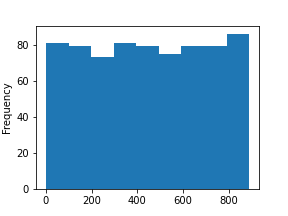

### 1.2 test set


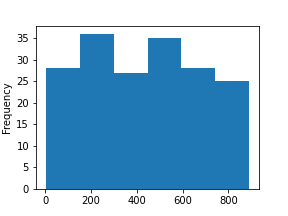

----------

## 2. Survived

### 2.1 train set


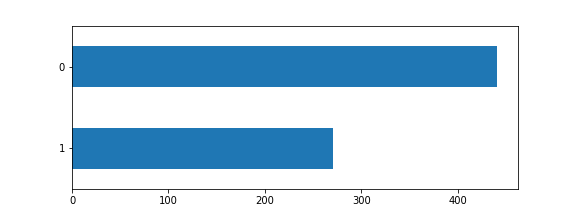
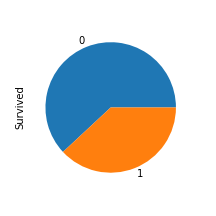

Test set has not column "Survived".

----------

## 3. Pclass

### 3.1 train set


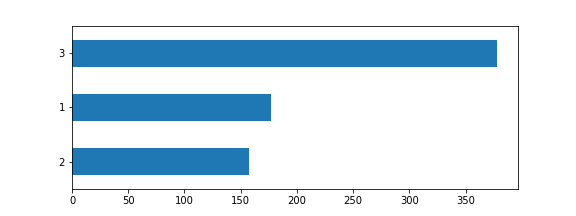
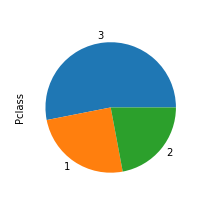

### 3.2 test set


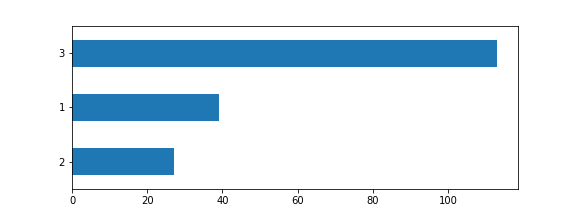
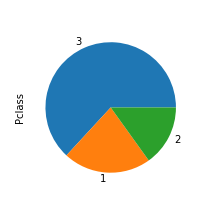

----------

## 4. Name

### 4.1 train set


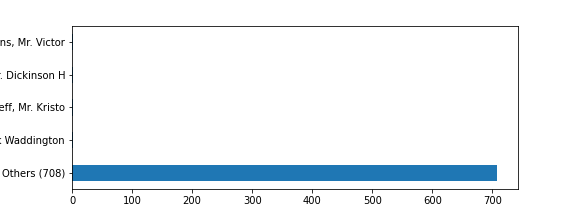
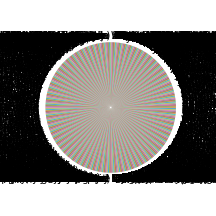

### 4.2 test set


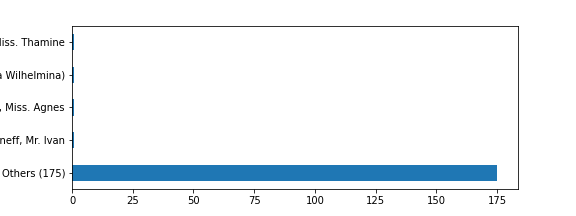
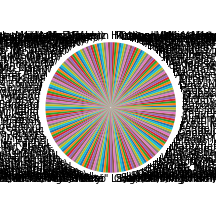

----------

## 5. Sex

### 5.1 train set


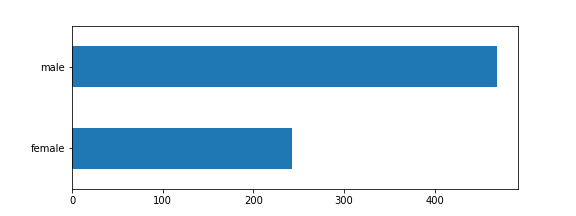
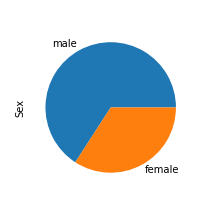

### 5.2 test set


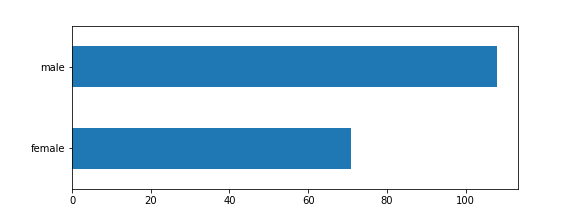
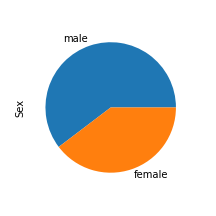

----------

## 6. Age

### 6.1 train set


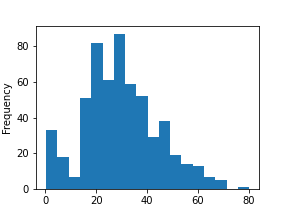

### 6.2 test set


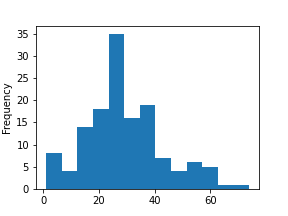

----------

## 7. SibSp

### 7.1 train set


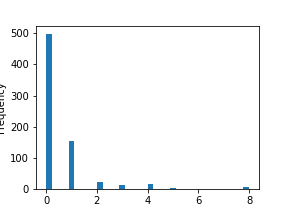

### 7.2 test set


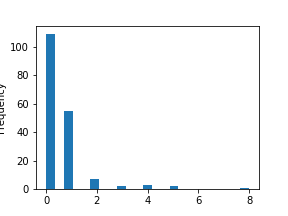

----------

## 8. Parch

### 8.1 train set


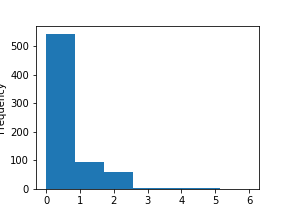

### 8.2 test set


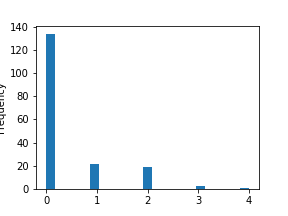

----------

## 9. Ticket

### 9.1 train set


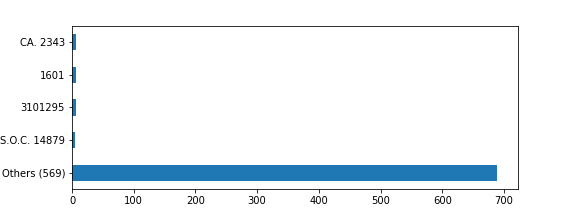
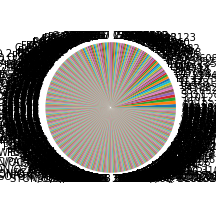

### 9.2 test set


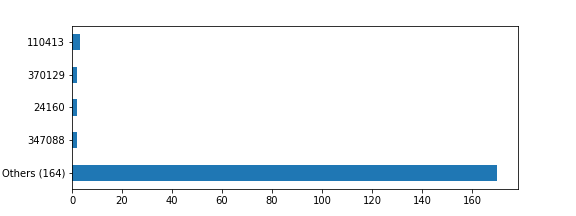
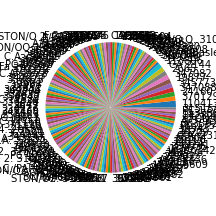

----------

## 10. Fare

### 10.1 train set


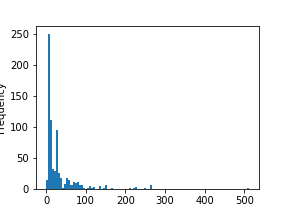

### 10.2 test set


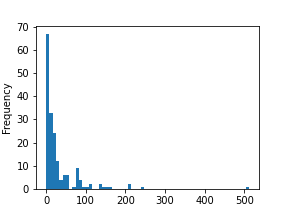

----------

## 11. Cabin

### 11.1 train set


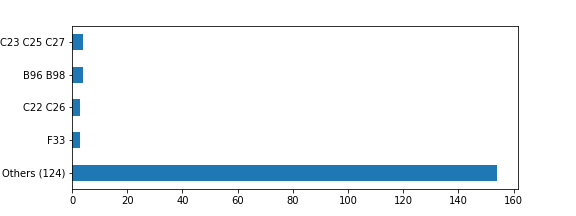
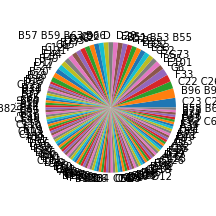

### 11.2 test set


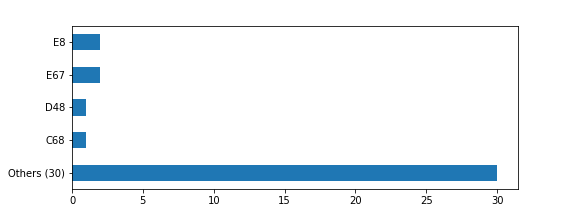
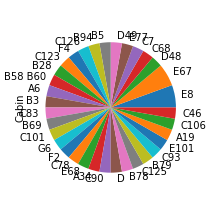

----------

## 12. Embarked

### 12.1 train set


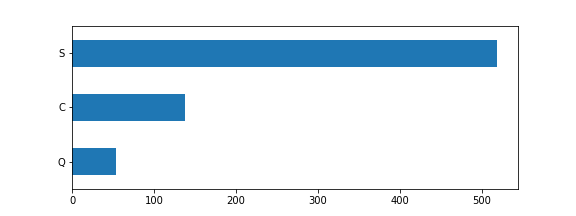
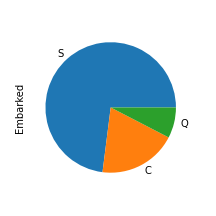

### 12.2 test set


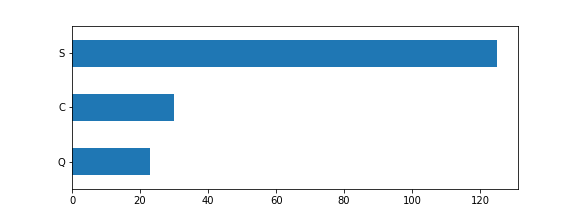
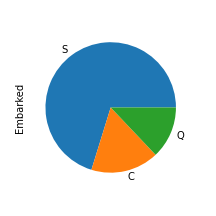

----------

In [989]:
display(Markdown(f'# Titanic Variables'))
# Train/Test 분포를 비교해보는 랜더링 테스트
for idx, col in enumerate(df_titanic_train.columns.values):
    display(Markdown(f'## {idx+1}. {col}'))
    display(Markdown(f'### {idx+1}.1 train set'))
    render_variable(df_titanic_train, col)
    if col in df_titanic_test.columns:
        display(Markdown(f'### {idx+1}.2 test set'))
        render_variable(df_titanic_test, col)
    else:
        display(Markdown(f'Test set has not column "{col}".'))
    display(Markdown(f'----------'))

#### 판다스 프로파일링 

In [89]:
from pandas_profiling import ProfileReport

In [957]:
# report2 = ProfileReport(df_diamonds, title='Profile Report', html={'style': {'full_width':True}})
# report2

In [956]:
# report = ProfileReport(df_boston, title='Profile Report', html={'style': {'full_width':True}})
# report

# 3. Plot function

+ plot_num2num
    - 수치형 변수로 수치형 변수의 분포를 파악
    - 다이아몬드 캐럿의 크기와 가격의 분포
    - df, num_col, target_col, hue=None, shape=None
    - scatter plot
+ plot_cat2num
    - 카테고리형 변수로 수치형 변수의 분포를 파악
    - 다이아몬드 색상에 따른 가격대의 분포
    - df, cat_col, target_col
    - box plot
+ plot_cat2cat
    - 카테고리형 변수로 카테고리형 변수의 분포를 파악
    - 객실등급에 따른 생존률 분포
    - df, cat_col, target_col, opt_col(C x C -> C)
    - 옵션 : sample count, normalized count
    - bar plot
+ plot_num2cat
    - 수치형 변수로 카테고리형 변수의 분포를 파악
    - 평균 3개월 ARPU에 따른 해지 분포
    - df, num_col, target_col, 
    - histogram, kde plot

In [1088]:
# def plot_feature2target(df, feature, target, plot_type=None, hue=None, style=None, **kwargs):
#     bypass = kwargs.get('bypass', False)
#     return_ax = kwargs.get('return_ax', False)
#     save_only = kwargs.get('save_only', False)
#     image_fn = kwargs.get('image_fn', f'img/feature2target_{feature}_{target}.png')
#     figsize = kwargs.get('figsize', (7,5))
    
#     if pd.api.types.is_numeric_dtype(df[feature]) and pd.api.types.is_numeric_dtype(df[target]):
#         ax = plot_num2num(df, feature, target, hue=hue, style=style, **kwargs)
    
# plot_feature2target(df_dia_train, 'carat', 'price', hue='color', style='cut')

In [1030]:
def plot_num2num(df, num_col, target_col, hue=None, style=None, **kwargs):
    '''
    example
    ----------
    >>> plot_num2num(df_dia_train, 'carat', 'price', hue='color', style='cut', save_only=False, figsize=(12,8))
    >>> plot_num2num(df_dia_train, 'carat', 'price', hue='color', style='cut', bypass=True, figsize=(12,8))
    '''
    bypass = kwargs.get('bypass', False)
    return_ax = kwargs.get('return_ax', False)
    save_only = kwargs.get('save_only', False)
    image_fn = kwargs.get('image_fn', f'img/num2num_{num_col}_{target_col}.png')
    figsize = kwargs.get('figsize', (7,5))
    
    plt.figure(figsize=figsize)
    ax = sns.scatterplot(data=df, x=num_col, y=target_col, hue=hue, style=style)
    
    if return_ax:
        return ax
    
    if save_only:
        ax.figure.savefig(image_fn)
        plt.close(ax.figure)
        return image_fn
    
    if bypass:
        return df
    
# plot_num2num(df_dia_train, 'carat', 'price', hue='color', style='cut')

In [1065]:
def plot_cat2num(df, cat_col, target_col, hue=None, **kwargs):
    '''
    example
    ----------
    >>> plot_cat2num(df_dia_train, 'color', 'price', save_only=True)
    >>> plot_cat2num(df_dia_train, 'color', 'price', hue='cut', figsize=(15, 8))
    '''
    bypass = kwargs.get('bypass', False)
    return_ax = kwargs.get('return_ax', False)
    save_only = kwargs.get('save_only', False)
    image_fn = kwargs.get('image_fn', f'img/cat2num_{cat_col}_{target_col}.png')
    figsize = kwargs.get('figsize', (7,5))
    
    plt.figure(figsize=figsize)
    ax = sns.boxplot(data=df, x=cat_col, y=target_col, hue=hue)
    
    if return_ax:
        return ax
    
    if save_only:
        ax.figure.savefig(image_fn)
        plt.close(ax.figure)
        return image_fn
    
    if bypass:
        return df

# plot_cat2num(df_dia_train, 'color', 'price', save_only=True)
# plot_cat2num(df_dia_train, 'color', 'price', hue='cut', figsize=(15, 8))

In [1227]:
def plot_cat2cat(df, cat_col, target_col, col=None, col_wrap=None, normalized=False, **kwargs):
    '''
    example
    ----------
    >>> plot_cat2cat(df_titanic_train, 'Pclass', 'Survived', col='Sex')
    >>> plot_cat2cat(df_titanic_train, 'Pclass', 'Survived')
    >>> plot_cat2cat(df_titanic_train, 'Pclass', 'Survived', normalized=True)
    >>> plot_cat2cat(df_titanic_train, 'Pclass', 'Survived', normalized=False, save_only=False)
    '''
    bypass = kwargs.get('bypass', False)
    return_ax = kwargs.get('return_ax', False)
    save_only = kwargs.get('save_only', False)
    image_fn = kwargs.get('image_fn', f'img/cat2cat_{cat_col}_{target_col}.png')
    figsize = kwargs.get('figsize', (7,5))
    
    plt.figure(figsize=figsize)
    
    if normalized:
        ax = (df
         .pipe(lambda df: pd.crosstab(df[cat_col], df[target_col]))
         .pipe(lambda df: df.div(df.sum(axis=1), axis=0))
         .plot(kind='bar', stacked=True)
        )   
    else:
        g = sns.catplot(data=df, x=cat_col, kind='count', hue=target_col, col=col, col_wrap=col_wrap)
        ax = g.ax
    
    if return_ax:
        return ax
    
    if save_only:
        ax.figure.savefig(image_fn)
        plt.close(ax.figure)
        return image_fn

    if bypass:
        return df
    
# plot_cat2cat(df_titanic_train, 'Pclass', 'Survived', normalized=True)
# plot_cat2cat(df_titanic_train, 'Pclass', 'Survived', normalized=True, save_only=True)

In [1104]:
def plot_num2cat(df, cat_col, target_col, multiple='layer', **kwargs):
    '''
    example
    ----------
    >>> plot_num2cat(df_titanic, 'Age', 'Survived', multiple='fill')
    >>> plot_num2cat(df_titanic, 'Age', 'Survived', multiple='layer')
    '''
    bypass = kwargs.get('bypass', False)
    return_ax = kwargs.get('return_ax', False)
    save_only = kwargs.get('save_only', False)
    image_fn = kwargs.get('image_fn', f'img/num2cat_{cat_col}_{target_col}.png')
    figsize = kwargs.get('figsize', (7,5))
        
    plt.figure(figsize=figsize)
    ax = sns.kdeplot(data=df, x=cat_col, hue=target_col, multiple=multiple)
    
    if return_ax:
        return ax
    
    if save_only:
        ax.figure.savefig(image_fn)
        plt.close(ax.figure)
        return image_fn

    if bypass:
        return df
    
# plot_num2cat(df_titanic, 'Age', 'Survived', multiple='fill')
# plot_num2cat(df_titanic, 'Age', 'Survived', multiple='layer')

In [1264]:
def plot_interface(func):
    def wrapper(*args, **kwargs):
        bypass = kwargs.get('bypass', False)
        return_ax = kwargs.get('return_ax', False)
        save_only = kwargs.get('save_only', False)
        image_fn = kwargs.get('image_fn', f'img/{func.__name__}_{args[1]}_{args[2]}.png')
        figsize = kwargs.get('figsize', (7,5))
        
        plt.figure(figsize=figsize)
        ax, df = func(*args, **kwargs)
        
        print()
        
        if return_ax:
            return ax

        if save_only:
            ax.figure.savefig(image_fn)
            plt.close(ax.figure)
            return image_fn

        if bypass:
            return df
        
    return wrapper

@plot_interface
def plot_num2num(df, num_col, target_col, hue=None, style=None, **kwargs):
    '''
    example
    ----------
    >>> plot_num2num(df_dia_train, 'carat', 'price', hue='color', style='cut', save_only=False, figsize=(12,8))
    >>> plot_num2num(df_dia_train, 'carat', 'price', hue='color', style='cut', bypass=True, figsize=(12,8))
    '''
    ax = sns.scatterplot(data=df, x=num_col, y=target_col, hue=hue, style=style)
    return ax, df

@plot_interface
def plot_cat2num(df, cat_col, target_col, hue=None, **kwargs):
    '''
    example
    ----------
    >>> plot_cat2num(df_dia_train, 'color', 'price', save_only=True)
    >>> plot_cat2num(df_dia_train, 'color', 'price', hue='cut', figsize=(15, 8))
    '''
    ax = sns.boxplot(data=df, x=cat_col, y=target_col, hue=hue)
    return ax, df

def plot_cats2num(df, cat_cols, num_col, **kwargs):
    '''
    example
    ----------
    >>> plot_cats2num(df_titanic, ['Survived', 'Pclass'], 'Age')
    '''
    assert(len(cat_cols) == 2)
    bypass = kwargs.get('bypass', False)
    height = kwargs.get('height', 2.2)
    aspect = kwargs.get('aspect', 1.5)
    
    grid = sns.FacetGrid(df, col=cat_cols[0], row=cat_cols[1], height=height, aspect=aspect)
    grid.map(plt.hist, num_col, alpha=.5, bins=20)
    grid.add_legend();

    if bypass:
        return df
    
@plot_interface
def plot_cat2cat(df, cat_col, target_col, col=None, col_wrap=None, normalized=False, **kwargs):
    '''
    example
    ----------
    >>> plot_cat2cat(df_titanic_train, 'Pclass', 'Survived', col='Sex')
    >>> plot_cat2cat(df_titanic_train, 'Pclass', 'Survived')
    >>> plot_cat2cat(df_titanic_train, 'Pclass', 'Survived', normalized=True)
    >>> plot_cat2cat(df_titanic_train, 'Pclass', 'Survived', normalized=False, save_only=False)
    '''
    if normalized:
        ax = (df
         .pipe(lambda df: pd.crosstab(df[cat_col], df[target_col]))
         .pipe(lambda df: df.div(df.sum(axis=1), axis=0))
         .plot(kind='bar', stacked=True)
        )   
    else:
        g = sns.catplot(data=df, x=cat_col, kind='count', hue=target_col, col=col, col_wrap=col_wrap)
        ax = g.axes
        
    return ax, df

@plot_interface
def plot_num2cat(df, cat_col, target_col, multiple='layer', **kwargs):
    '''
    example
    ----------
    >>> plot_n2c(df_titanic, 'Age', 'Survived', multiple='fill')
    >>> plot_n2c(df_titanic, 'Age', 'Survived', multiple='layer')
    '''
    ax = sns.kdeplot(data=df, x=cat_col, hue=target_col, multiple=multiple)
    return ax, df

def plot_cats2binary(df, cat_cols, target_col, hue=None, **kwargs):
    '''
    example
    --------
    1) category nums == 3
    >>> plot_cats2binary(df_titanic, ['Pclass', 'Sex', 'Embarked'], 'Survived')
    2) category nums == 2
    >>> plot_cats2binary(df_titanic, ['Pclass', 'Sex'], 'Survived')
    3) category nums == 1
    >>> plot_cats2binary(df_titanic.assign(relatives = lambda df: df.Parch + df.SibSp), ['relatives'], 'Survived')
    '''
    assert(len(df[target_col].unique()) == 2)
    bypass = kwargs.get('bypass', False)
    height = kwargs.get('height', 3)
    aspect = kwargs.get('aspect', 1.4)

    # len(cat_cols) == 3
    if len(cat_cols) == 3:
        FacetGrid = sns.FacetGrid(df, col=cat_cols[2], height=height, aspect=aspect)
        FacetGrid.map(sns.pointplot, cat_cols[0], target_col, cat_cols[1], palette=None,  order=None, hue_order=None )
        FacetGrid.add_legend()

    # len(cat_cols) == 2
    if len(cat_cols) == 2:
        sns.pointplot(data=df, x=cat_cols[0], y=target_col, hue=cat_cols[1])

    # len(cat_cols) == 1
    if len(cat_cols) == 1:
        sns.catplot(data=df, x=cat_cols[0], y=target_col, kind="point", hue=hue, aspect = 2.5)
        
    plt.show()
    
    if bypass:
        return df

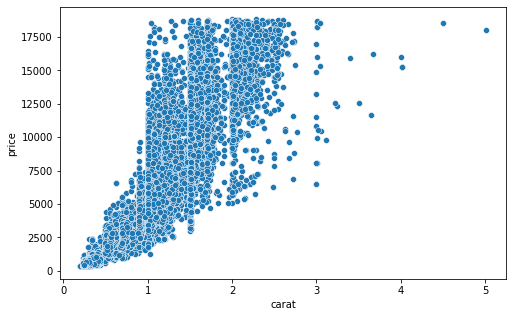

In [1266]:
plot_num2num(df_dia_train, 'carat', 'price', save_only=False, figsize=(8,5))

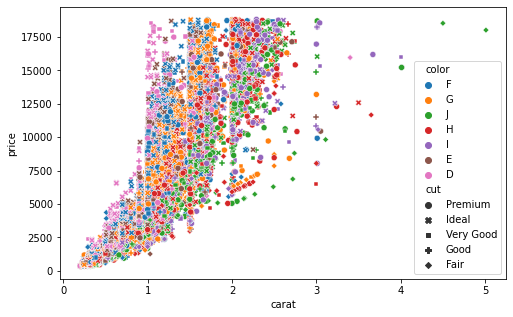

In [1236]:
plot_n2n(df_dia_train, 'carat', 'price', hue='color', style='cut', save_only=False, figsize=(8,5))

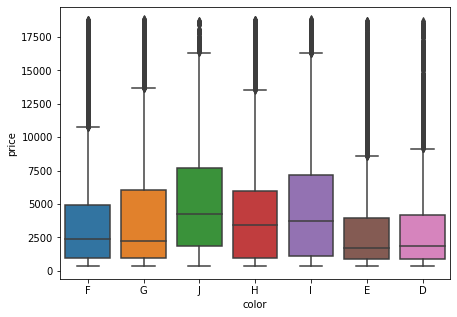

In [1241]:
plot_c2n(df_dia_train, 'color', 'price')

<Figure size 504x360 with 0 Axes>

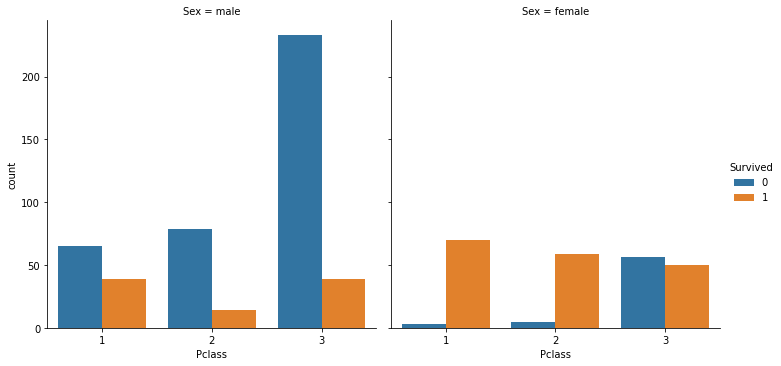

In [1248]:
plot_c2c(df_titanic_train, 'Pclass', 'Survived', col='Sex')

<Figure size 504x360 with 0 Axes>

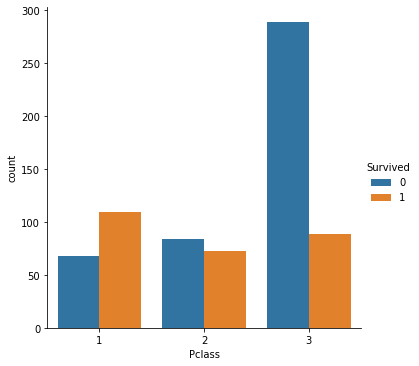

In [1249]:
plot_c2c(df_titanic_train, 'Pclass', 'Survived')

<Figure size 504x360 with 0 Axes>

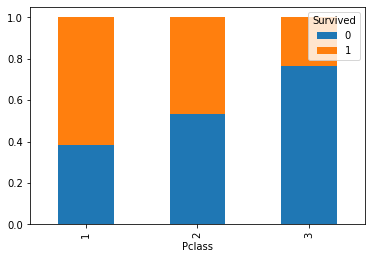

In [1250]:
plot_c2c(df_titanic_train, 'Pclass', 'Survived', normalized=True)

<Figure size 504x360 with 0 Axes>

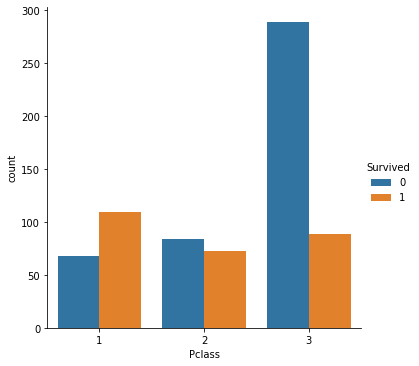

In [1251]:
plot_c2c(df_titanic_train, 'Pclass', 'Survived', normalized=False, save_only=False)

### 

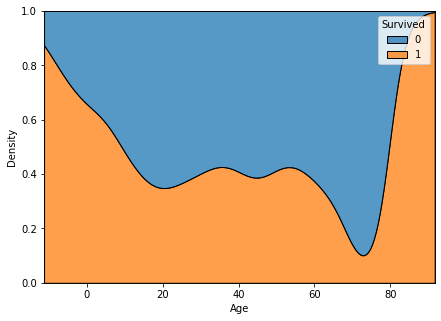

In [1253]:
plot_n2c(df_titanic, 'Age', 'Survived', multiple='fill')

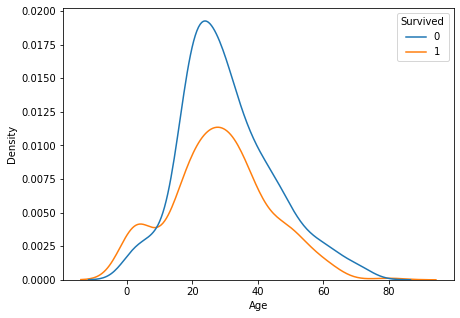

In [1254]:
plot_n2c(df_titanic, 'Age', 'Survived', multiple='layer')